# Detect fake tweet with logistic regression


# Importing library


In [1]:
!pip install textstat

     |████████████████████████████████| 99 kB 396 kB/s eta 0:00:011
     |████████████████████████████████| 1.9 MB 1.5 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
#nltk.download('wordnet')
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt')
import sklearn as sk #this is the most popular library for statistics and machine learning
import matplotlib.pyplot as plt 
import os
import itertools
import collections
import re
import textstat
import networkx
import warnings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import wordnet as wn
from nltk import pos_tag
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
from sklearn import metrics
import string
from collections import Counter


## Reading data and summarizing

In [3]:
df = pd.read_csv('../input/fakenews/tweets_labeled.csv')
df.head(10)

,tweet_id,text,label
0,1161040537207463936,'RT @SenJeffMerkley: The Endangered Species Ac...,1
1,1176360756239118342,'RT @LindseyGrahamSC: Interesting concept -- i...,1
2,1099036648573145088,'RT @RealJamesWoods: #BuildTheWall #DeportThem...,0
3,1092915693203480577,'RT @PatriotJackiB: Why would the MEXICAN GOV’...,0
4,1149038450668187654,'RT @TheOnion: Sweden Announces Plan To Get 10...,0
5,1175456815674343424,'RT @kcResister: Warren: 'Congress is complici...,1
6,1180809117310623744,'RT @ShimonPro: A dozen current and former sta...,1
7,1179840318935576578,'RT @samstein: This is a bombshell that isn’t ...,1
8,1081722778125062144,'Planned Parenthood Erects Billboards Urging W...,0
9,1158761795739217921,'https://t.co/MvrznF1fWVWhoever obstructing th...,1


In [4]:
df.shape

(225405, 3)

In [5]:
df = df[['text','label']]

Remove duplicates:

In [6]:
# df = df.drop_duplicates(subset=['text'],keep='first')

In [7]:
df.shape

(225405, 2)

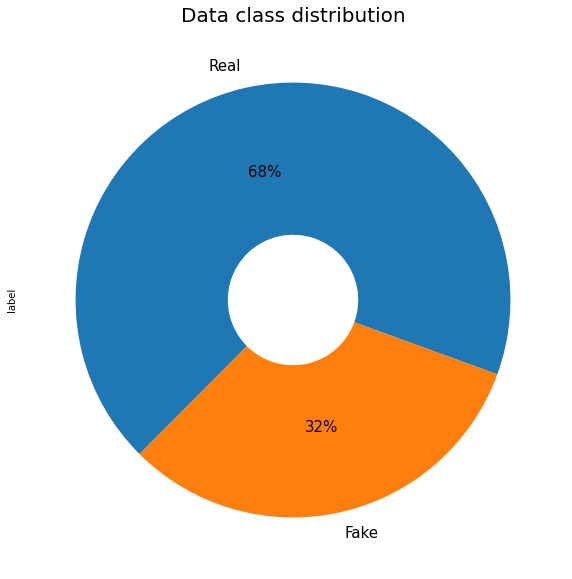

In [8]:
plt.figure(figsize=(30,10))
plt.title('Data class distribution', fontsize=20)
df.label.value_counts().plot(kind='pie', labels=['Real', 'Fake'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})

## Feature Extraction

Hashtags

In [9]:
def contains_hashtag(tweet):
    if '#' in tweet:
        return 1
    else:
        return 0
    
df['contains_hashtag'] = df['text'].apply(lambda x: contains_hashtag(x))

In [10]:
def count_hashtag(tweet):
    return tweet.count('#')

df['count_hashtag'] = df['text'].apply(lambda x: count_hashtag(x))

Links

In [11]:
def contains_link(tweet):
    if 'https://' in tweet:
        return 1
    else:
        return 0
    
df['contains_link'] = df['text'].apply(lambda x: contains_link(x))

In [12]:
def count_link(tweet):
    return tweet.count('https://')

df['count_link'] = df['text'].apply(lambda x: contains_link(x))

Mentions

In [13]:
def contains_mention(tweet):
    if '@' in tweet:
        return 1
    else:
        return 0
    
df['contains_mention'] = df['text'].apply(lambda x: contains_mention(x))

In [14]:
def count_mention(tweet):
    return tweet.count('@')

df['count_mention'] = df['text'].apply(lambda x: count_mention(x))

Retweets

In [15]:
def is_retweet(tweet):
    regexp = re.compile('(RT @.*: )')
    if regexp.search(tweet):
        return 1
    else:
        return 0

df['is_retweet'] = df['text'].apply(lambda x: is_retweet(x))

Checking "..."

In [16]:
def count_3dots(tweet):
    return tweet.count('…') + tweet.count('...')

df['count_3dots'] = df['text'].apply(lambda x: count_3dots(x))

Letters

In [17]:
def count_capital_letters(tweet):
    return sum(1 for c in tweet if c.isupper())

df['count_capital_letters'] = df['text'].apply(lambda x: count_capital_letters(x))

In [18]:
def count_capital_letters_to_length(tweet):
    return sum(1 for c in tweet if c.isupper()) / len(tweet)

df['count_capital_letters_to_length'] = df['text'].apply(lambda x: count_capital_letters_to_length(x))

Stopwords

In [19]:
stop_words = set(stopwords.words('english'))
def count_stop_words(tweet):
    word_tokens = word_tokenize(tweet)
    return sum(1 for w in word_tokens if w in stop_words)

df['count_stop_words'] = df['text'].apply(lambda x: count_stop_words(x))

Special characters

In [20]:
def count_special_chars(tweet):
    word_tokens = word_tokenize(tweet)
    return sum(1 for w in word_tokens if w in stop_words)

df['count_special_chars'] = df['text'].apply(lambda x: count_special_chars(x))

In [21]:
def count_special_chars(tweet):
    count = 0
    for i in range(0, len(tweet)):
    # len(string) function to count the 
    # number of characters in given string.      
        #.isalpha() function checks whether character 
        #is alphabet or not.
        if (tweet[i].isalpha()):
            continue
        #.isdigit() function checks whether character 
        #is a number or not.
        elif (tweet[i].isdigit()):
            continue
        else:
            count += 1
            
    return count

df['count_special_chars'] = df['text'].apply(lambda x: count_special_chars(x))

Digits

In [22]:
def count_digits(tweet): 
    count = 0
    for i in range(0, len(tweet)):
        if (tweet[i].isdigit()):
            count += 1
    return count

df['count_digits'] = df['text'].apply(lambda x: count_digits(x))

Alphabets

In [23]:
def count_alphabets(tweet): 
    count = 0
    for i in range(0, len(tweet)):
        if (tweet[i].isalpha()):
            count += 1
    return count

df['count_alphabets'] = df['text'].apply(lambda x: count_alphabets(x))

Before cleaning (bc) textual features

In [24]:
df['bc_length'] = df['text'].apply(lambda x: len(x))
df['bc_words_count'] = df['text'].apply(lambda x: len(x.split()))
df['bc_words_average_length'] = df['text'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))

Removing emoji

In [25]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

df['text'] = df['text'].apply(lambda x: remove_emoji(x))

Other textual features

In [26]:
df['count_open_parentheses'] = df['text'].apply(lambda x: x.count('('))
df['count_close_parentheses'] = df['text'].apply(lambda x: x.count(')'))
df['count_exclamation_mark'] = df['text'].apply(lambda x: x.count('!'))
df['count_question_mark'] = df['text'].apply(lambda x: x.count('?'))
df['count_|'] = df['text'].apply(lambda x: x.count('|'))
df['count_percentage_sign'] = df['text'].apply(lambda x: x.count('%'))
df['count_comma'] = df['text'].apply(lambda x: x.count(','))
df['count_plus'] = df['text'].apply(lambda x: x.count('+'))
df['count_minus'] = df['text'].apply(lambda x: x.count('-'))

## Cleaning

Removing unwanted characters as symbols

In [27]:
def clean_word():
    word = df['text'].str.replace(r'RT\s', '')
    word = word.str.replace("}", "")
    word = word.str.replace("{", "")
    word = word.str.replace("-", "")
    word = word.str.replace("--", "")
    word = word.str.replace("|", "")
    word = word.str.replace("¦", "")
    word = word.str.replace(",", "")
    word = word.str.replace(".", "")
    word = word.str.replace(":", "")
    word = word.str.replace("?", "")
    word = word.str.replace("#", "")
    word = word.str.replace("(", "")
    word = word.str.replace(")", "")
    word = word.str.replace("!", "")
    word = word.str.replace(";", "")
    word = word.str.replace("&", "")
    word = word.str.replace("'", "")
    word = word.str.replace('—', "")
    word = word.str.replace("i'm", "i am")
    word = word.str.replace("it's", "it is")
    word = word.str.replace(r'RT\s', '')
    word = word.str.replace(r'@\S*?\s', '')
    word = word.str.replace(r'@\S*?$', '')
    word = word.str.replace(r'https\S*?\s', ' ')  
    word = word.str.replace(r'https\S*?$', '')
    word = word.str.replace('\'', '')
    word = word.str.replace(r'…', '')
    word = word.str.replace(r'\s$', '')
    df['text'] = word 
    
clean_word()

## Other Features (After Cleaning)

Count of words

In [28]:
stop = stopwords.words('english')

def words_only_count(tweet):
    words = tweet.split()
    words_only = [word for word in words if word not in stop and
              not word.startswith(('#', '@'))]
    return len(words_only)

df['words_only_count'] = df['text'].apply(lambda x: words_only_count(x))

## Sentiment Features: polarity and subjectivity

We take subjectivity and polarity of the each text as a feature.

In [29]:
from textblob import TextBlob
opinion = TextBlob("That great because that is!")
df['polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [30]:
df['is_positive'] = df['polarity'].apply(lambda x: 1 if x > 0 else 0)
df['is_negative'] = df['polarity'].apply(lambda x: 1 if x < 0 else 0)
df['is_neutral'] = df['polarity'].apply(lambda x: 1 if x == 0 else 0)

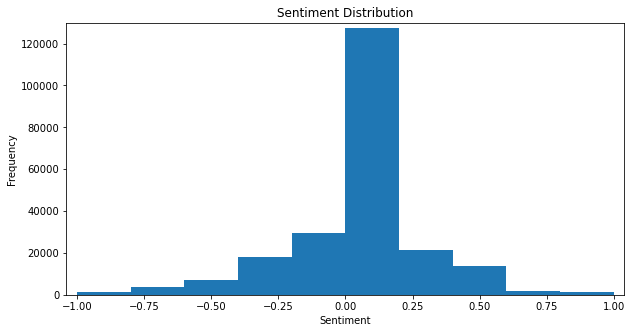

In [31]:
plt.figure(figsize=(10,5))
plt.margins(0.02)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.hist(df['polarity'])
plt.title('Sentiment Distribution')
plt.show()

## POS Features

All POS counts that exists in tweets

In [32]:
from textblob import TextBlob
from textblob.taggers import NLTKTagger
nltk_tagger = NLTKTagger()

for i, row in df.iterrows():
    blob = TextBlob(row["text"], pos_tagger=nltk_tagger)
    for elem1 in blob.pos_tags:
        count = 0
        for elem2 in blob.pos_tags:
            if elem1[1] == elem2[1]:
                count += 1
        df.at[i,'COUNT_'+elem1[1]] = count

## Word Clouds

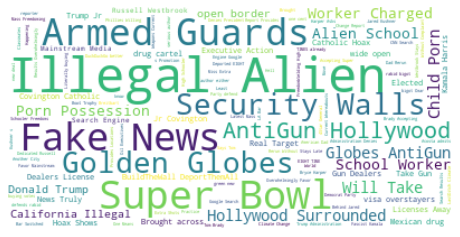

In [33]:
from wordcloud import WordCloud

text = " ".join([x for x in df[df['label'] == 0].text])

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

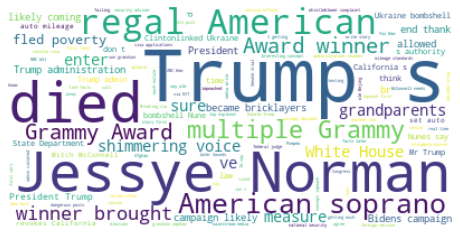

In [34]:
text = " ".join([x for x in df[df['label'] == 1].text])

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## Word Frequency

Extracting 20 most frequent words in fake tweets

trump :  18220
ukraine :  7859
president :  5519
house :  4583
new :  4179
whistleblower :  4065
says :  3435
news :  3305
trumps :  3124
american :  2682
impeachment :  2524
time :  2514
campaign :  2449
like :  2250
call :  2241
trump’s :  2216
award :  2198
multiple :  2178
amp :  2168
administration :  2153


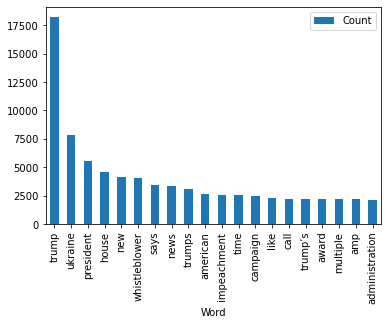

In [35]:
import collections
stop_words = set(stopwords.words('english'))
text = " ".join([x for x in df[df['label'] == 1].text])

wordcount = {}
for word in text.lower().split():
    if word not in stop_words and len(word) > 2:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
            
n_print = 20

word_counter = collections.Counter(wordcount)

for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
    

lst = word_counter.most_common(n_print)
dftemp = pd.DataFrame(lst, columns = ['Word', 'Count'])
dftemp.plot.bar(x='Word',y='Count')

Add 20 features for most frequent words

In [36]:
# for elem in lst:
#     df['count_positive_' + elem[0]] = df['text'].apply(lambda x: x.lower().count(elem[0]))

In [37]:
def check_contains_freq_words(text, words):
    for word in words:
        if word in text:
            return 1
    return 0

In [38]:
def count_freq_words(text, words):
    count = 0
    for word in words:
        count +=text.count(word)
    return count

Feature: Count of 20 frequent words of fake tweets

In [39]:
positive_words = []
for elem in lst:
    positive_words.append(elem[0])
    
# df['has_positive_frequent_words'] = df['text'].apply(lambda x: check_contains_freq_words(x, positive_words))
df['count_positive_freq_words'] = df['text'].apply(lambda x: count_freq_words(x, positive_words))

Extracting 20 most frequent words in real tweets

trump :  12885
illegal :  8339
brought :  6589
one :  6166
search :  5961
google :  5403
california :  5180
breitbart :  5095
media :  4825
he’s :  4716
news :  4677
alien :  4619
new :  4616
charged :  4557
border :  4491
gun :  4446
child :  4376
miss :  4373
fake :  4283
security :  4205


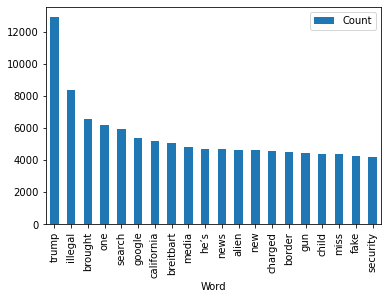

In [40]:
stop_words = set(stopwords.words('english'))
text = " ".join([x for x in df[df['label'] == 0].text])

wordcount = {}
for word in text.lower().split():
    if word not in stop_words and len(word) > 2:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
            
n_print = 20

word_counter = collections.Counter(wordcount)

for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
    

lst = word_counter.most_common(n_print)
dftemp = pd.DataFrame(lst, columns = ['Word', 'Count'])
dftemp.plot.bar(x='Word',y='Count')

In [41]:
# for elem in lst:
#     df['count_negative_' + elem[0]] = df['text'].apply(lambda x: x.lower().count(elem[0]))

Feature: Count of 20 frequent words of real tweets

In [42]:
negative_words = []
for elem in lst:
    negative_words.append(elem[0])
    
# df['has_negative_frequent_words'] = df['text'].apply(lambda x: check_contains_freq_words(x, negative_words))
df['count_negative_freq_words'] = df['text'].apply(lambda x: count_freq_words(x, negative_words))

## Bigrams

In [43]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

Most frequent bigrams of real tweets

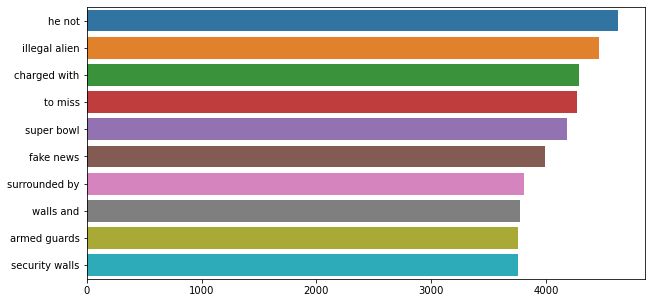

In [44]:
plt.figure(figsize=(10,5))
top_tweet_bigrams = get_top_tweet_bigrams(df[df['label'] == 0]['text'])[:10]
x,y = map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [45]:
# for elem in top_tweet_bigrams:
#     df['count_bigrams_negative_' + elem[0]] = df['text'].apply(lambda x: x.lower().count(elem[0]))

Feature: Count of most frequent bigrams of real tweets

In [46]:
negative_bigrams = []
for elem in top_tweet_bigrams:
    negative_bigrams.append(elem[0])
    
# df['has_negative_frequent_bigrams'] = df['text'].apply(lambda x: check_contains_freq_words(x, negative_bigrams))
df['count_negative_freq_bigrams'] = df['text'].apply(lambda x: count_freq_words(x, negative_bigrams))

Most frequent bigrams of fake tweets

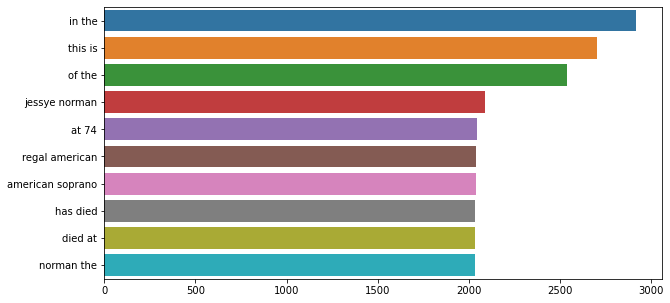

In [47]:
plt.figure(figsize=(10,5))
top_tweet_bigrams = get_top_tweet_bigrams(df[df['label'] == 1]['text'])[:10]
x,y = map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [48]:
# for elem in top_tweet_bigrams:
#     df['count_bigrams_positive_' + elem[0]] = df['text'].apply(lambda x: x.lower().count(elem[0]))

Feature: Count of most frequent bigrams of fake tweets

In [49]:
positive_bigrams = []
for elem in top_tweet_bigrams:
    positive_bigrams.append(elem[0])
    
# df['has_positive_frequent_bigrams'] = df['text'].apply(lambda x: check_contains_freq_words(x, positive_bigrams))
df['count_positive_freq_bigrams'] = df['text'].apply(lambda x: count_freq_words(x, positive_bigrams))

Other textual features of after cleaning (ac)

In [50]:
df['ac_length'] = df['text'].apply(lambda x: len(x))
df['ac_words_count'] = df['text'].apply(lambda x: len(x.split()))

In [51]:
df['readability'] = df['text'].apply(textstat.flesch_reading_ease)

List of all columns

In [52]:
list(df.columns)

['text',
 'label',
 'contains_hashtag',
 'count_hashtag',
 'contains_link',
 'count_link',
 'contains_mention',
 'count_mention',
 'is_retweet',
 'count_3dots',
 'count_capital_letters',
 'count_capital_letters_to_length',
 'count_stop_words',
 'count_special_chars',
 'count_digits',
 'count_alphabets',
 'bc_length',
 'bc_words_count',
 'bc_words_average_length',
 'count_open_parentheses',
 'count_close_parentheses',
 'count_exclamation_mark',
 'count_question_mark',
 'count_|',
 'count_percentage_sign',
 'count_comma',
 'count_plus',
 'count_minus',
 'words_only_count',
 'polarity',
 'subjectivity',
 'is_positive',
 'is_negative',
 'is_neutral',
 'COUNT_DT',
 'COUNT_NNP',
 'COUNT_VBD',
 'COUNT_NN',
 'COUNT_CC',
 'COUNT_VBN',
 'COUNT_IN',
 'COUNT_JJ',
 'COUNT_VBZ',
 'COUNT_TO',
 'COUNT_VBG',
 'COUNT_RB',
 'COUNT_VB',
 'COUNT_NNS',
 'COUNT_VBP',
 'COUNT_WRB',
 'COUNT_MD',
 'COUNT_WP',
 'COUNT_PRP',
 'COUNT_NNPS',
 'COUNT_CD',
 'COUNT_WDT',
 'COUNT_PRP$',
 'COUNT_JJR',
 'COUNT_RBR',
 'CO

In [53]:
print("Count of features:",(len(df.columns) - 2))

Count of features: 74


Fill null values of POS features with 0 (for those didn't have that feature)

In [54]:
df = df.fillna(0)

Run above cell for saving features along with the data

In [55]:
# df_org = pd.read_csv('../input/fakenews/tweets_labeled.csv')
# df['text_org'] = df_org['text']
# df['tweet_id'] = df_org['tweet_id']
# df.to_csv("tweets_with_features.csv", index=False)

## Correlation between features and label

Plot correlations before modeling

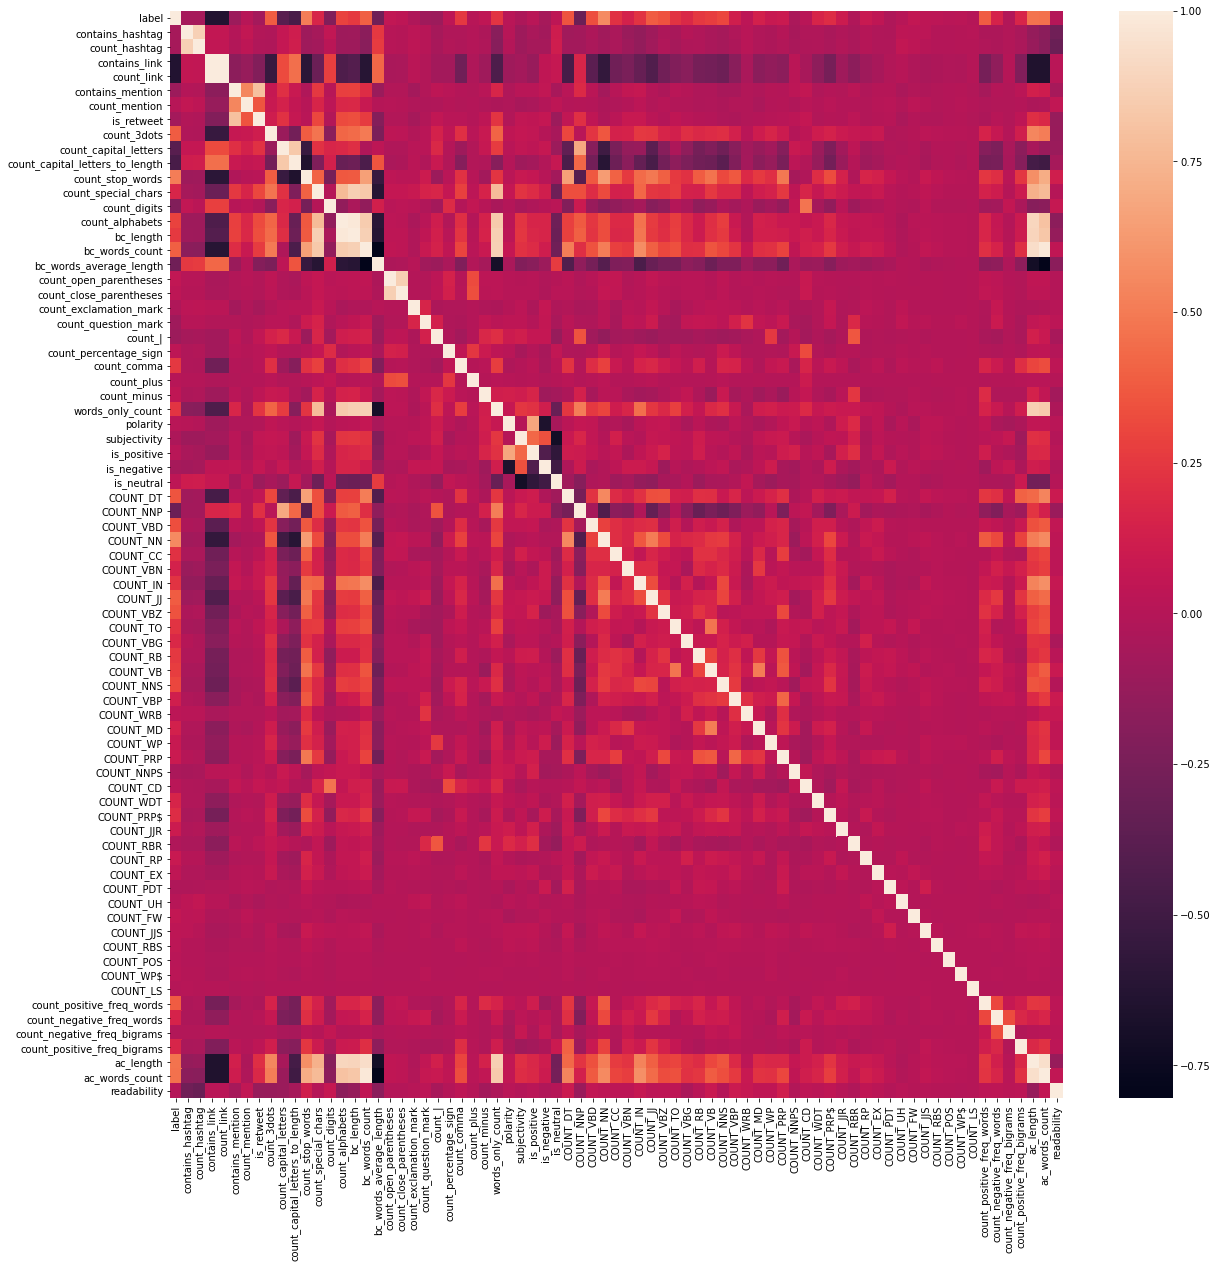

In [56]:
plt.figure(figsize=(20,20))
sns.heatmap(df.loc[:, ~df.columns.isin(['text'])].corr())

# Modeling

First we split the data to two sets. Test set and training set. 20% of data is for testing and 80% is for training.

In [57]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.loc[:, ~df.columns.isin(['text', 'label'])], df[['label']], test_size=0.2, random_state=42)

Here we create our mode, we use the logistic regression model of sklearn package.

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

Train the data to fit to the training set.

In [59]:
pipe.fit(x_train, y_train.values.ravel())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [60]:
pipe.score(x_test, y_test)

0.8985381868192809

## Evaluation

Calculate the accuracy:

In [61]:
# Print the accuracy score of the classifier
print(f"Validation Accuracy of Logsitic Regression Classifier is: {(pipe.score(x_test, y_test))*100:.2f}%")

Validation Accuracy of Logsitic Regression Classifier is: 89.85%


Get the confusion matrix to see how our model worked on test set.

In [62]:
cm = metrics.confusion_matrix(y_test, pipe.predict(x_test))
print(cm)

[[28949  1787]
 [ 2787 11558]]


Plot the confusion matrix:

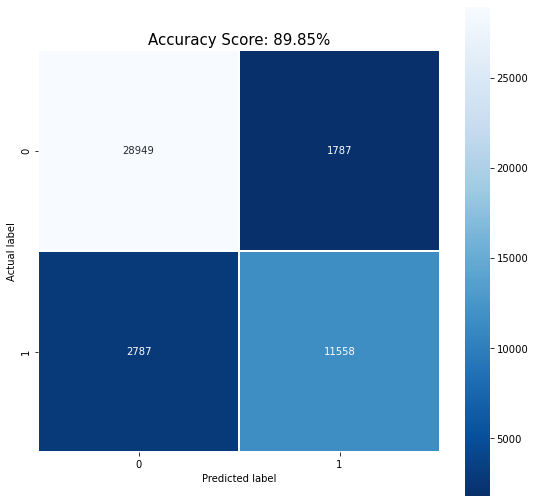

In [63]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'Accuracy Score: {(pipe.score(x_test, y_test))*100:.2f}%'
plt.title(all_sample_title, size = 15);

Details of accuracy, recall, and f1-score:

In [64]:
print(metrics.classification_report(y_test, pipe.predict(x_test), target_names = ['0', '1']))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93     30736
           1       0.87      0.81      0.83     14345

    accuracy                           0.90     45081
   macro avg       0.89      0.87      0.88     45081
weighted avg       0.90      0.90      0.90     45081



ROC: Receiver operating characteristic

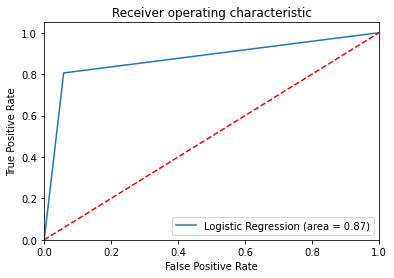

In [65]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, pipe.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, pipe.predict(x_test))

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Relative Feature Importance

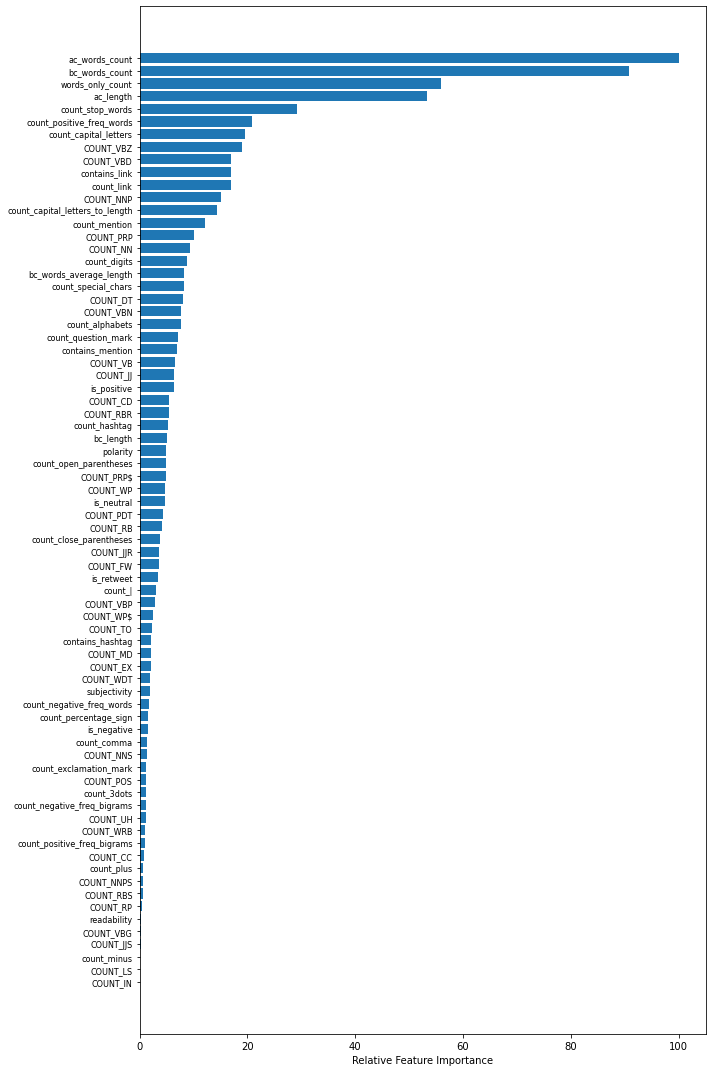

In [100]:
from mpl_toolkits.axisartist.axislines import Subplot

feature_importance = abs(pipe['logisticregression'].coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize =(10, 15)) 

featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(x_train.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()